# Data Acquisition
This is the notebook whereby I obtain the labeled image set that will be for this project. I will use several geographic datasets covering the Denver metro area to create the API requests against the Google StreetView static API. 
Because of licensing on the API, I am not able to making the images available, but if you obtain a developer key you can use this notebook to download a similar dataset.

In [46]:
try:
    import google.colab
    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

if IN_COLAB:
    import os
    # install modules
    !pip install geopandas
    !pip install shapely
    !pip install pyproj
    from google.colab import drive
    drive.mount('/content/gdrive')

In [45]:
if IN_COLAB:
    os.chdir(f'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data')
    ! unzip sidewalks_deep-learning.zip -d '/content/data/'
    os.getcwd()

3:42: E225 missing whitespace around operator
3:42: E225 missing whitespace around operator


In [14]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.stats import ttest_ind
import shapely
from shapely.ops import nearest_points
from shapely.geometry import Point, LinearRing, LineString
import matplotlib.pyplot as plt
import seaborn as sns
import random
from os import path
import urllib.request
import requests
import pickle
from math import atan2, degrees, pi
import pyproj
from tqdm import tqdm
import urllib, os, json
from sklearn.neighbors import KernelDensity
from math import pi

18:14: E401 multiple imports on one line


In [15]:
%load_ext pycodestyle_magic
%pycodestyle_on

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


# Get Geographic Datasets

In [16]:
down_loc = os.getcwd()
down_loc

'C:\\Users\\User\\Documents\\GitHub\\sidewalks_deep-learning'

In [17]:
pwd

'C:\\Users\\User\\Documents\\GitHub\\sidewalks_deep-learning'

In [ ]:
# download data sources if not there
data_urls = {}
data_urls['sidewalk_extent'] = r'https://gis.drcog.org/geoserver/DRCOGPUB/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=DRCOGPUB:planimetrics_2016_extent_centerline_sidewalks&outputFormat=application%2Fjson'
data_urls['sidewalk_centerlines'] = r'https://gis.drcog.org/geoserver/DRCOGPUB/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=DRCOGPUB:planimetrics_2016_centerline_sidewalks&outputFormat=application%2Fjson'
data_urls['road_polygons'] = r'https://gis.drcog.org/geoserver/DRCOGPUB/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=DRCOGPUB:planimetrics_2016_eop_poly&outputFormat=application%2Fjson'
if not IN_COLAB:
    for key, value in data_urls.items():
        if not path.exists(key + ".geojson"):
            urllib.request.urlretrieve(value, key + '.geojson')

In [21]:
if IN_COLAB:
    sidewalk_gdf = gpd.read_file('/content/data/sidewalk_centerlines.geojson')
    sidewalk_extent_gdf = gpd.read_file('/content/data/sidewalk_extent.geojson')
    road_polygons_gdf = gpd.read_file('/content/data/road_polygons.geojson')
else:
    sidewalk_gdf = gpd.read_file('sidewalk_centerlines.geojson')
    sidewalk_extent_gdf = gpd.read_file('sidewalk_extent.geojson')
    road_polygons_gdf = gpd.read_file('road_polygons.geojson')

3:80: E501 line too long (80 > 79 characters)
3:80: E501 line too long (80 > 79 characters)


In [30]:
sidewalk_gdf.head()

,id,gid,createdate,createuser,type,comments,update_sta,unique_id,geometry
0,planimetrics_2016_centerline_sidewalks.534414,534414,2016-04-08,Kucera,Sidewalk,None,N,534414,"MULTILINESTRING ((-105.15545 39.97195, -105.15..."
1,planimetrics_2016_centerline_sidewalks.534415,534415,2016-04-08,Kucera,Sidewalk,None,N,534415,"MULTILINESTRING ((-105.15954 39.97177, -105.15..."
2,planimetrics_2016_centerline_sidewalks.534416,534416,2016-04-08,Kucera,Other crossing,None,N,534416,"MULTILINESTRING ((-105.15479 39.97196, -105.15..."
3,planimetrics_2016_centerline_sidewalks.534417,534417,2016-04-08,Kucera,Sidewalk,None,N,534417,"MULTILINESTRING ((-105.15457 39.97196, -105.15..."
4,planimetrics_2016_centerline_sidewalks.534418,534418,2016-04-08,Kucera,Sidewalk,None,N,534418,"MULTILINESTRING ((-105.15479 39.97196, -105.15..."


In [23]:
sidewalk_extent_gdf.head()

,id,gid,sqmi,geometry
0,planimetrics_2016_extent_centerline_sidewalks.1,1,1378.109985,"MULTIPOLYGON (((3138537.128 1894378.599, 31385..."


In [31]:
road_polygons_gdf.head()

,id,gid,createdate,createuser,surface,type,comments,update_sta,unique_id,geometry
0,planimetrics_2016_eop_poly.1,1,2015-07-08,Kucera,Paved,Corridor,None,M,1,"MULTIPOLYGON (((-104.86738 39.69979, -104.8673..."
1,planimetrics_2016_eop_poly.2,2,2015-07-08,Kucera,Paved,Corridor,None,M,2,"MULTIPOLYGON (((-104.87066 39.70060, -104.8706..."
2,planimetrics_2016_eop_poly.3,3,2015-07-08,Kucera,Paved,Corridor,None,M,3,"MULTIPOLYGON (((-104.87544 39.69653, -104.8754..."
3,planimetrics_2016_eop_poly.4,4,2015-07-08,Kucera,Paved,Corridor,None,M,4,"MULTIPOLYGON (((-104.89093 39.70081, -104.8908..."
4,planimetrics_2016_eop_poly.5,5,2015-07-08,Kucera,Paved,Corridor,None,M,5,"MULTIPOLYGON (((-104.88979 39.70986, -104.8897..."


### check/fix geometry projection

In [32]:
total_bounds = sidewalk_gdf.geometry.total_bounds
total_bounds

array([-105.73042154,   39.22868711, -104.04058364,   40.52299314])

In [33]:
sidewalk_extent_gdf.geometry.total_bounds

array([2932503.25159384, 1503238.87488092, 3414549.89051701,
       1991021.48166284])

Note: desired bounds: 39-41; - 104-106. These are standard *WGS84* AKA *EPSG 4326*

In [34]:
sidewalk_extent_gdf.geometry.crs

{'init': 'epsg:6428'}

In [38]:
road_polygons_gdf = road_polygons_gdf.to_crs(epsg=4326)

In [36]:
sidewalk_gdf = sidewalk_gdf.to_crs(epsg=4326)
sidewalk_gdf.crs

{'init': 'epsg:4326', 'no_defs': True}

In [37]:
sidewalk_extent_gdf = sidewalk_extent_gdf.to_crs(epsg=4326)
print(f'sidewalk extent crs:{sidewalk_extent_gdf.geometry.crs} \nexample coordinates {sidewalk_extent_gdf.geometry.centroid}')

2:80: E501 line too long (126 > 79 characters)
2:80: E501 line too long (126 > 79 characters)


### Latitude & Longitude:
Coordinates for sidewalk data set are in *Longitude*, **Latitude** format. 
Google Streetview API takes **Latitude**, *Longitude* format.

# Find Points and Download Images

## Image Downloading Class

In [39]:
class image_grabber(object):
    '''
    Creates random points and tests for appropriateness for image downloading. 
    Generates heading for appropriate points. 
    Downloads images from google maps api based on generated coordinates & heading. 
    Args:
        sidewalks: sidewalk outline geodataframe
        sidewalk_polygon: outline of area surveyd for sidewalks
        road_polygons: outline of roads (so image capture direction can be toward sidewalks)
        direc: path to save images
        distance_to_sidewalk: meters along heading to look for sidewalk line
        dim: tuple with dimensions to obtain image in
        fov: field of view in degrees for images
        radius: how far to look from random point for goog pano
        verbose: print update as images found
    Attributes:
        confirmed_locations = created by .generate_numbers() method. contains list of [Heading, [shapely.Point]] items
        locations_w_label = created by .get_labels() method. has list of [Heading, [lat, lon], label] items
        met_lis: list items are [date, panoID, filename]
    Example Usage:
        image_grab = image_grabber()
        image_grab.generate_numbers(1)
        image_grab.download_images()
    TODO: 
        Fix excess use of self.* naming
    '''
    def __init__(self, sidewalks=sidewalk_gdf, sidewalk_polygon=sidewalk_extent_gdf.geometry, 
                 road_polygons=road_polygons_gdf, 
                 direc=os.path.join(os.getcwd(), "images"), distance_to_sidewalk=12,
                img_dim=(800,800), fov=90, radius=100, verbose=1):
        self.sidewalks = sidewalks
        self.sidewalk_polygon = sidewalk_polygon
        self.road_polygons = road_polygons
        self.confirmed_locations = []
        self.locations_w_label = []
        self.metadata_url = ""
        self.direc = direc
        self.geod = pyproj.Geod(ellps='WGS84') #standard projection
        self.image_list = []
        self.PrevImage = []
        self.dist_to_sdwlk = distance_to_sidewalk
        self.url_list = []
        self.img_dim = img_dim
        self.fov = fov
        self.base = r"https://maps.googleapis.com/maps/api/streetview"
        self.size = r"?size=" + str(self.img_dim[0]) + 'x' + str(self.img_dim[1]) + '&fov=' + str(self.fov)
        (self.min_lon, self.min_lat, self.max_lon, self.max_lat) = self.sidewalk_polygon.total_bounds
        self.radius= radius
        self.show_image = False
        self.verbose = verbose
    #utility methods
    def degree_fixer(self, x):
        return x if x >0 else 180-x
    def degree_unfixer(self, x):
        return x if x <= 180 else -x
    def poly_decomposer(self, geo_obj):
        '''
        take complex geo object and convert to geo dataframe with geometry column
        Args:
            geo_obj: shapely multi object
        returns:
            geodataframe with geometry column
        '''
        decomp = gpd.GeoDataFrame()
        decomp['geometry'] = None
        for obj in geo_obj:
            decomp.loc[decomp.shape[0]+1,'geometry'] = obj.exterior
            for o in obj.interiors:
                decomp.loc[decomp.shape[0]+1,'geometry'] = o
        return decomp
    
    #methods for instance use            
    def generate_numbers(self, number):
        '''
        generate random locations within boundaries
        '''
        self.number = number
        self.counter = 0
        while self.counter < self.number:
            self.pnt = Point(random.uniform(self.min_lon, self.max_lon), 
                             random.uniform(self.min_lat, self.max_lat))
            if not self.sidewalk_polygon.contains(self.pnt).any(0):
                continue
            closest_obj = self.closest_obj_finder(point=self.pnt, objects=road_polygons_gdf.copy())   
            if not closest_obj.contains(self.pnt): # check for both because first check is much faster
                continue
            # get direction towards nearest street edge, eg direction towards sidewalk
            #create urls from components
            self.keyloc="google_dev_key.key"
            with open(self.keyloc, 'r') as self.keyfile:
                self.google_key=self.keyfile.read()[:-1]  # needed to strip newline char
            self.loc = '&location=' + str(self.pnt.y) + "," + str(self.pnt.x) +  "&radius=" + str(self.radius) 
            self.metadata_url = self.base + r"/metadata" + self.size + self.loc + "&key=" + self.google_key

            # get metadata and updated pnt to nearest pano location
            self.met_lis = self.MetaParse() #[location, panoID]
            if self.met_lis[0] is None:
                continue
            self.pnt = Point(self.met_lis[0]['lng'], self.met_lis[0]['lat'])
            #find nearest point in road dataframe
            decomposed_mpoly = self.poly_decomposer(closest_obj)
            nearest_pnt = nearest_points(self.closest_obj_finder(self.pnt, decomposed_mpoly), self.pnt)[0]
            #find a heading (cartographical azimuth from North)

            #DONT KNOW WHY THIS DOESN'T WORK, but have to recreate Geod
            #inv = self.geod.inv(lons1=self.pnt.y, lats1=self.pnt.x,
            #                                 lons2=nearest_pnt.y, lats2=nearest_pnt.x)            
            geod_wgs84 = pyproj.Geod(ellps='WGS84')
            inv = geod_wgs84.inv(lons1=self.pnt.x, lats1=self.pnt.y, 
                                lons2=nearest_pnt.x, lats2=nearest_pnt.y, radians=False)
            (direction, _, _1) = inv
            
            direction = self.degree_fixer(direction)
            result = [direction, self.pnt]
            self.confirmed_locations.append(result)
            if self.verbose > 0: print(f'{self.counter+1} of {self.number} locations generated.', end='\r')
            self.counter += 1
    def closest_obj_finder(self, point, objects):
        '''
        finds closest point on a geoframe's geometry. 
        Args:
             point: baseline point
             objects: object set within which to find nearest object 
             find_count: how many obj to find
        returns shapely object that is closest from within geodf passed 
        '''
        objects['dist_to_pnt'] = objects.geometry.apply(lambda obj: obj.distance(point))
        objects = objects.sort_values(by=['dist_to_pnt'])
        closest_object = objects[objects.index.values == objects.iloc[[0],:]
                          .apply(lambda obj: nearest_points(obj.geometry, point)[0], axis=1)
                          .index.values].geometry.values[0]
        return closest_object

    def _to_coords(self, location):
        '''
        change shapely points to list with reverse order of points; [heading, [lon,lat]]->[heading, [lat,lon]]
        '''
        return [location[0], [item[0] for item in location[1].xy][::-1]]
    
    def get_labels(self):
        '''
        determines if sidewalk exists on street in direction of heading
        No args or return
        removed itmes from self.confirmed_locations, 
            adds heading, 
            and appends to self.locations_w_label
        '''
        while self.confirmed_locations:
            self.location = self.confirmed_locations.pop()
            self.direction, self.pnt = self.location
            self.lons, self.lats = self.pnt.xy
            self.closest_sidewalk = self.closest_obj_finder(self.pnt, self.sidewalks)
            self.endpnt_lons, self.endpnt_lat, _ = self.geod.fwd(lons=self.lons, 
                                                                 lats=self.lats, 
                                                                 az=self.direction, 
                                                                 dist=self.dist_to_sdwlk, 
                                                                 radians=False)
            endpnt = Point(self.endpnt_lons[0], self.endpnt_lat[0])
            camera_line = LineString([self.pnt, endpnt])
            camera_buff = camera_line.buffer(.0001)
            intersection = True if self.closest_sidewalk.intersects(camera_buff) else False
            self.label="sidewalk" if intersection else 'no_sidewalk'

            self.clean_loc=self._to_coords(self.location)
            self.clean_loc.append(self.label)
            self.locations_w_label.append(self.clean_loc)
            
    def MetaParse(self):
        '''
        Uses metadata url to retrieve metadata for the pano image.
        Args:
            metadata_url: A string containing a valid url
        Returns:
             A tuple with the json data date and the pano_id
        '''
        self.response = urllib.request.urlopen(self.metadata_url)
        self.json_raw = self.response.read()
        self.json_data = json.loads(self.json_raw)
        #return data from json response
        if self.json_data['status'] == "OK":
            return [self.json_data['location'], self.json_data['pano_id']]
        else:
            return [None,None]

    def GetStreetvw(self, radius=1000):
        '''
        Downloads images from google api based on parameters specified. 
        Note: Dev key is unique to each user. To run this notebook, create your own dev key and
        store in directory in a text file of this name.
        Args:
            img_dim: tuple of int specifying image size
            fov: degrees of field of view for image
            radius: meters for radius of search area for nearest pano
        Returns:
             A list item of images downloaded.
             Main effect of function is to download images into directory.
        '''
        #get location to download
        self.location_to_process = self.locations_w_label.pop()
        [self.Head, [self.Lat, self.Lon], self.label] = self.location_to_process
        if self.show_image: self.check_via_plot(self.location_to_process)
        self.SaveLoc = self.direc + self.label        
        
        #get key
        self.keyloc="google_dev_key.key"
        with open(self.keyloc, 'r') as self.keyfile:
            self.google_key=self.keyfile.read()[:-1]  # needed to strip newline char
        #update urls
        self.loc = '&location=' + str(self.Lat) + "," + str(self.Lon) +  "&radius=" + str(self.radius) 
        self.file_url = self.base + self.size + self.loc + "&key=" + self.google_key
        self.file_name = "lat" + str(self.Lat) + "lon" + str(self.Lon) + "head" + str(self.Head) + ".jpg"

        #download files
        if (self.met_lis[1], self.Head) not in self.image_list:
            with requests.Session() as self.urlrequest:
                self.image = self.urlrequest.get(self.file_url)
            self.filename=os.path.join(os.getcwd(), 'images', self.label, self.file_name)
            with open(self.filename, 'wb') as self.openfile:
                self.openfile.write(self.image.content)
            self.PrevImage.append((self.met_lis[1], self.Head, self.file_url)) 

        #delete key to avoid storing in public github-hosted notebook state backup
        del(self.google_key)
        return self.met_lis
    def download_images(self, show_image=False):
        '''
        Iterates through the downloading method. Second main public use method.
        '''
        #create directories
        self.show_image = show_image
        if not path.exists(self.direc):
            os.mkdir(self.direc) 
        self.label_subdirs = ['sidewalk', 'no_sidewalk']
        for self.subdir in self.label_subdirs:
            if not path.exists(os.path.join(self.direc, self.subdir)):
                os.mkdir(os.path.join(self.direc, self.subdir))
        
        #get labels
        self.get_labels()
        #download!
        self.lwlsize = len(self.locations_w_label)
        for i in range(0,self.lwlsize):
            self.GetStreetvw()
            if self.verbose >0: print(f'\r{i+1} of {self.lwlsize} images downloaded.', end='\r')
    def check_via_plot(self, location):
        '''
        visualize chosen point from which pano was snapped and direction it looks.
        Plotted as vector of distance within which to look for sidewalk.
        Won't work for number>=1
        '''
        [Head, [Lat, Lon], label] = location
        print(location)
        Lon2, Lat2, _ = self.geod.fwd(lons=Lon, lats=Lat, 
                                      az=self.degree_unfixer(Head),
                                      dist=self.dist_to_sdwlk, radians=False)
        
        dx = Lon2 - Lon
        dy = Lat2 - Lat

        xrange = sorted([Lon, Lon2])
        yrange = sorted([Lat, Lat2])

        rangemax = 5*max(abs(xrange[1]-xrange[0]), abs(yrange[1]-yrange[0]))
        xrange = sorted([xrange[0] - rangemax, xrange[1] + rangemax])
        yrange = sorted([yrange[0] - rangemax, yrange[1] + rangemax])

        #plot geometries
        plt.style.use("ggplot")
        fig_checkvp, ax = plt.subplots(figsize = (12,12))
        sidewalk_gdf.geometry.plot(facecolor='g', linewidth=0, edgecolor='g', alpha=0.7, ax=ax, label='sidewalk')
        road_polygons_gdf.geometry.plot(facecolor='r', linewidth=0, edgecolor='r', alpha=.7, ax=ax, label='road')
        arrow = plt.arrow(x=Lon, y=Lat, dx=dx, dy=dy, width=.000005)
        ax.add_patch(arrow)
        print(f'xrange{xrange}, yrange: {yrange}')
        ax.set_xlim(*xrange)
        ax.set_ylim(*yrange)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.legend()
        ax.set_title('Location of Image Requested with POV Vector', fontsize=20)
        plt.plot();

3:79: W291 trailing whitespace
4:46: W291 trailing whitespace
5:80: E501 line too long (83 > 79 characters)
5:84: W291 trailing whitespace
9:80: E501 line too long (92 > 79 characters)
17:80: E501 line too long (118 > 79 characters)
18:80: E501 line too long (107 > 79 characters)
24:10: W291 trailing whitespace
27:80: E501 line too long (93 > 79 characters)
27:94: W291 trailing whitespace
28:50: W291 trailing whitespace
29:80: E501 line too long (84 > 79 characters)
30:17: E128 continuation line under-indented for visual indent
30:29: E231 missing whitespace after ','
38:47: E261 at least two spaces before inline comment
38:48: E262 inline comment should start with '# '
46:80: E501 line too long (107 > 79 characters)
47:80: E501 line too long (101 > 79 characters)
48:20: E225 missing whitespace around operator
51:5: E265 block comment should start with '# '
52:5: E301 expected 1 blank line, found 0
53:24: E225 missing whitespace around operator
54:5: E301 expected 1 blank line, found 0

107:80: E501 line too long (87 > 79 characters)
107:88: W291 trailing whitespace
109:69: W291 trailing whitespace
110:33: E128 continuation line under-indented for visual indent
110:80: E501 line too long (88 > 79 characters)
112:1: W293 blank line contains whitespace
116:32: E701 multiple statements on one line (colon)
116:80: E501 line too long (107 > 79 characters)
118:5: E301 expected 1 blank line, found 0
120:54: W291 trailing whitespace
123:69: W291 trailing whitespace
125:72: W291 trailing whitespace
127:80: E501 line too long (88 > 79 characters)
129:74: E231 missing whitespace after ','
130:27: E128 continuation line under-indented for visual indent
130:80: E501 line too long (92 > 79 characters)
131:27: E128 continuation line under-indented for visual indent
136:80: E501 line too long (110 > 79 characters)
139:1: W293 blank line contains whitespace
144:53: W291 trailing whitespace
145:26: W291 trailing whitespace
152:80: E501 line too long (85 > 79 characters)
153:80: E501 li

In [21]:
#image grabber driver
if IN_COLAB:
  image_grab = image_grabber(direc=f'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/images/',
                             verbose=0)
else:
  image_grab = image_grabber()

#### Example Use

[269.9812922349449, [40.06244274355016, -105.2067883010862], 'sidewalk']
xrange[-105.20749156871061, -105.20594437993692], yrange: [40.06173944055316, 40.06314601117456]


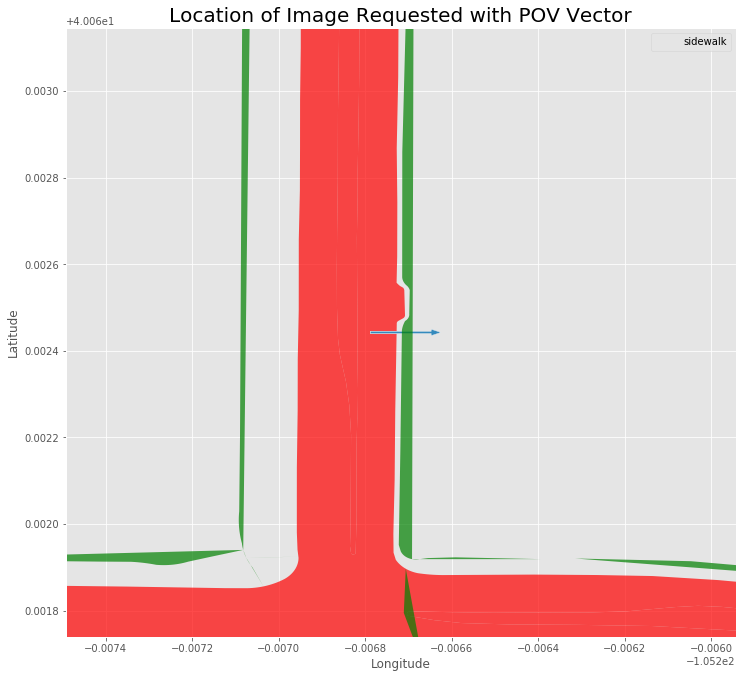

In [26]:
  image_grab.generate_numbers(1)
  image_grab.download_images(show_image=True)

In [ ]:
#For Mass Downloading
for _ in range(0, 400):
  image_grab.generate_numbers(20)
  image_grab.download_images(show_image=False)

## Issues with acquired data:
around 15% of the images acquired had incorrect labels. This could be for multiple reasons:
* old information (rapid population increase and building is keeping up with population)
* inaccurate classification
* partial sidewalk, where only a bit is in an image. How should we classify "partial sidewalk" in a binary classification task?
* ambiguous 'sidewalks' - there are a range of slightly angle pavement edges to asphalt streets that could be considered kerbless sidewalk, or just shoulder or open gutter.
* some panorams from google are rotated up to 90 degrees so may include part of the opposite road
* some pictures have cars blocking the edge of the road where a sidewalk might be

Because of this, to improve accuracy, I reviewed images manually to delete ambiguous and reassign clearly misclassified images before the modeling step.

### Plotting Data

In [22]:
# data sourced from https://data-cdphe.opendata.arcgis.com/datasets/66c2642209684b90af84afcc559a5a02_5
if not path.exists('CO_county_lines.kml'):
    CO_cnty_lines_url = r'https://opendata.arcgis.com/datasets/66c2642209684b90af84afcc559a5a02_5.kml?outSR=%7B%22latestWkid%22%3A4269%2C%22wkid%22%3A4269%7D'
    !curl -o CO_county_lines.kml $CO_cnty_lines_url

In [23]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
CO_county_lines_gdf = gpd.read_file('CO_county_lines.kml', driver='KML')

In [24]:
CO_county_lines_gdf.head()

,Name,Description,geometry
0,,,"POLYGON ((-105.05673 40.34929, -105.05664 40.3..."
1,,,"POLYGON ((-104.14319 37.75834, -104.14408 37.7..."
2,,,"POLYGON ((-105.36890 38.25941, -105.36889 38.2..."
3,,,"POLYGON ((-106.79970 38.97966, -106.80041 38.9..."
4,,,"POLYGON ((-106.14888 37.40111, -106.15066 37.4..."


In [25]:
CO_county_lines_gdf.geometry.crs

{'init': 'epsg:4326'}

 metadata from https://gis.drcog.org/rdc/xml/planimetrics_2016_centerline_sidewalks.xml

In [26]:
CO_county_lines_gdf.geometry.crs = {'init': 'epsg:4326'}

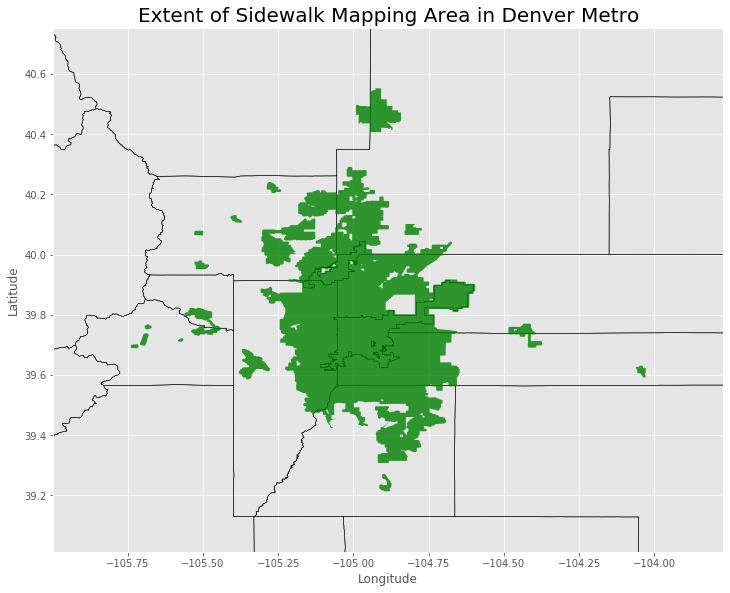

In [33]:
#establish boundaries
minx, miny, maxx, maxy = sidewalk_extent_gdf.geometry.total_bounds
xdiff = maxx - minx
ydiff = maxy - miny
maxx += .15*xdiff
minx -= .15*xdiff
maxy += .15*ydiff
miny -= .15*ydiff

#plot geometries
fig, ax = plt.subplots(figsize = (12,12))
CO_county_lines_gdf.geometry.plot(facecolor='none', linewidth=.5, edgecolor='k', ax=ax)
sidewalk_extent_gdf.geometry.plot(facecolor='g', linewidth=0, edgecolor='g', alpha=0.8, ax=ax)

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Extent of Sidewalk Mapping Area in Denver Metro', fontsize=20)
plt.plot();

# Results of Download

In [27]:
pwd

'C:\\Users\\User\\Documents\\GitHub\\sidewalks_deep-learning'

In [47]:
#switch to cloud dir
if IN_COLAB:
    os.chdir(f'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/images/')
else:
    os.chdir(os.path.expanduser(f'~/Google Drive/thinkful/colab_datasets/sidewalk_data/images/'))

In [48]:
# get list of all image filenames. filenames have location nfo
sidewalk_paths = [r'./train/sidewalk', r'./test/sidewalk']
no_sidewalk_paths =  [r'./train/no_sidewalk', r'./test/no_sidewalk']
sidewalk_locs, no_sidewalk_locs = [], []
for path in sidewalk_paths:
    sidewalk_locs.extend(os.listdir(path))
for path in no_sidewalk_paths:
    no_sidewalk_locs.extend(os.listdir(path))

In [49]:
# convert filenames to list of lat/long
def location_parser(location):
    lonstart = location.find('lon')
    headstart = location.find('head')
    end = location.find('.jpg')
    lat = location[3:lonstart]
    lon = location[lonstart+3:headstart]
    head = location[headstart+4:end]
    return [lat, lon, head]
no_sidewalk_locs1 = [location_parser(loc) for loc in no_sidewalk_locs]
sidewalk_locs1 = [location_parser(loc) for loc in sidewalk_locs]

### Calculate Distribution

In [56]:
#put lists of coordinates into geodataframe
sidewalk_locations_df = pd.DataFrame(sidewalk_locs1)
sidewalk_locations_df['label'] = "sidewalk"
sidewalk_locations_df.columns = ['lat', 'lon', 'head', 'label']
no_sidewalk_locations_df = pd.DataFrame(no_sidewalk_locs1)
no_sidewalk_locations_df['label'] = 'no_sidewalk'
no_sidewalk_locations_df.columns = ['lat', 'lon', 'head', 'label']
locations_df = pd.concat([sidewalk_locations_df, no_sidewalk_locations_df], axis=0, sort=False)
locations_df.describe()

,lat,lon,head,label
count,18289,18289,18289,18289
unique,18221,18220,18263,2
top,39.7719144,-104.8204497,90.79048386297497,sidewalk
freq,3,3,2,13145


In [58]:
locations_df.tail()

,lat,lon,head,label
5139,40.51400909520861,-104.890777788035,236.77397151432163,no_sidewalk
5140,40.51600599004363,-104.9078653562351,271.9334986243716,no_sidewalk
5141,40.52300394492477,-104.9273385964106,181.41562789010368,no_sidewalk
5142,40.53758674825909,-104.9375329959206,178.0129048658732,no_sidewalk
5143,40.53799413097843,-104.9138847034952,0.14140662740957724,no_sidewalk


In [66]:
for col in ['lat', 'lon', 'head']:
    locations_df[col]=locations_df[col].apply(float)

In [67]:
locations_gdf = gpd.GeoDataFrame(
    locations_df, geometry=gpd.points_from_xy(locations_df.lon, locations_df.lat))
locations_gdf.head()

,lat,lon,head,label,geometry
0,39.324606,-104.832560,196.327931,sidewalk,POINT (-104.83256 39.32461)
1,39.328895,-104.829727,240.371876,sidewalk,POINT (-104.82973 39.32889)
2,39.329842,-104.842133,62.398890,sidewalk,POINT (-104.84213 39.32984)
3,39.333132,-104.864206,31.523858,sidewalk,POINT (-104.86421 39.33313)
4,39.334461,-104.863530,325.554811,sidewalk,POINT (-104.86353 39.33446)


In [68]:
locations_gdf.geometry.crs = {'init': 'epsg=4326'}

In [69]:
#this is only approximate center, ignoring projection issues
lat_center = locations_gdf.lat.mean()
lon_center = locations_gdf.lon.mean()
images_center = Point(lon_center, lat_center)

In [70]:
locations_gdf['dist_to_center'] = locations_gdf.geometry.apply(images_center.distance)
locations_gdf.head()

,lat,lon,head,label,geometry,dist_to_center
0,39.324606,-104.832560,196.327931,sidewalk,POINT (-104.83256 39.32461),0.473264
1,39.328895,-104.829727,240.371876,sidewalk,POINT (-104.82973 39.32889),0.470002
2,39.329842,-104.842133,62.398890,sidewalk,POINT (-104.84213 39.32984),0.465531
3,39.333132,-104.864206,31.523858,sidewalk,POINT (-104.86421 39.33313),0.456741
4,39.334461,-104.863530,325.554811,sidewalk,POINT (-104.86353 39.33446),0.455607


In [79]:
no_side_dist = locations_gdf[locations_gdf.label=='no_sidewalk'].dist_to_center
side_dist = locations_gdf[locations_gdf.label=='sidewalk'].dist_to_center

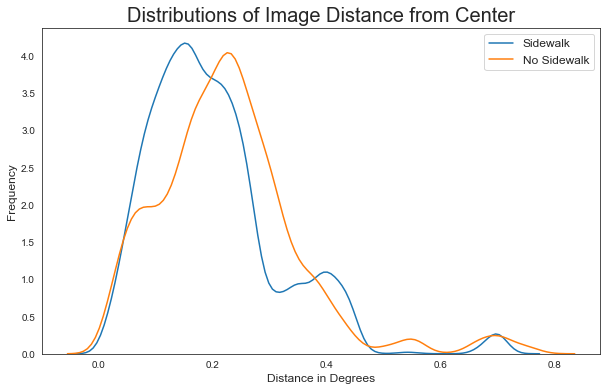

In [87]:
sns.set_style('white')
plt.figure(figsize=(10, 6))
sns.kdeplot(side_dist,
            #kde=False,
            label="Sidewalk")
sns.kdeplot(no_side_dist,
            #kde=False,
            label="No Sidewalk")
plt.title("Distributions of Image Distance from Center", fontsize=20)
plt.xlabel("Distance in Degrees", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=12);

In [95]:
ttest_result = ttest_ind(no_side_dist, side_dist)
print(f"Independent two tailed t-test results: \ntest statistic: {ttest_result[0]:.3f} \npvalue: {ttest_result[1]:.5f}")

Independent two tailed t-test results: 
test statistic: 13.885 
pvalue: 0.00000.


### Plot Distribution

In [278]:
# need Points to plot 
sidewalk_loc_xy = np.array([[float(loc[1]), float(loc[0])] for loc in sidewalk_locs1])
no_sidewalk_loc_xy = np.array([[float(loc[1]), float(loc[0])] for loc in no_sidewalk_locs1])
sidewalk_loc_headings = np.array([float(loc[2]) for loc in sidewalk_locs1])
no_sidewalk_loc_headings = np.array([float(loc[2]) for loc in no_sidewalk_locs1])

In [279]:
#get density estimate. score_samples returns log value
sidewalk_loc_kde = np.exp(KernelDensity().fit(X=sidewalk_loc_xy).score_samples(sidewalk_loc_xy))
no_sidewalk_loc_kde = np.exp(KernelDensity().fit(X=no_sidewalk_loc_xy).score_samples(no_sidewalk_loc_xy))

In [280]:
sidewalk_loc_kde = np.expand_dims(sidewalk_loc_kde, axis=1)  
no_sidewalk_loc_kde = np.expand_dims(no_sidewalk_loc_kde, axis=1)

In [286]:
sidewalk_xyk = np.concatenate((sidewalk_loc_xy, sidewalk_loc_kde), axis=1)
no_sidewalk_xyk = np.concatenate((no_sidewalk_loc_xy, no_sidewalk_loc_kde), axis=1)
sX, sY, sZ = sidewalk_xyk[:,0].tolist(), sidewalk_xyk[:,1].tolist(), sidewalk_xyk[:,2].tolist()
nosX, nosY, nosZ = no_sidewalk_xyk[:,0], no_sidewalk_xyk[:,1], no_sidewalk_xyk[:,2]

In [287]:
def location_plotter(dataset, title_insert):
    plt.style.use("fivethirtyeight")
    minx, miny, maxx, maxy = sidewalk_extent_gdf.geometry.total_bounds
    xdiff = maxx - minx
    ydiff = maxy - miny
    maxx += .05*xdiff
    minx -= .05*xdiff
    maxy += .05*ydiff
    miny -= .05*ydiff

    #plot geometries
    fig1, ax1 = plt.subplots(figsize = (8,8))
    sns.kdeplot(dataset[:,0], dataset[:,1], 
                    shade=True, gridsize=100, cut=0, 
                    clip=None, 
                    cmap="Purples_d",
                    shade_lowest=False, 
                    ax=ax1,
                    bw=.01,
                    )
    CO_county_lines_gdf.geometry.plot(facecolor='none', linewidth=.5, edgecolor='k', ax=ax1)
    sidewalk_extent_gdf.geometry.plot(facecolor='g', linewidth=.5, edgecolor='g', alpha=0, ax=ax1)
    levels = np.linspace(0, sidewalk_xyk[:,2].max(), 25)
    ax1.set_xlim(minx, maxx)
    ax1.set_ylim(miny, maxy)
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title(f'Density of {title_insert} Images', fontsize=20)
    plt.plot();

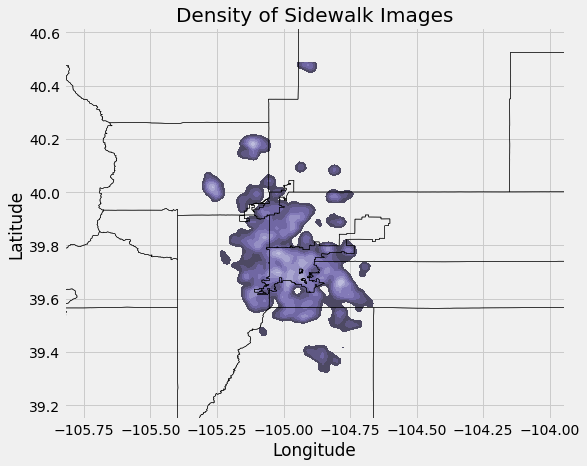

In [288]:
location_plotter(sidewalk_loc_xy, "Sidewalk")

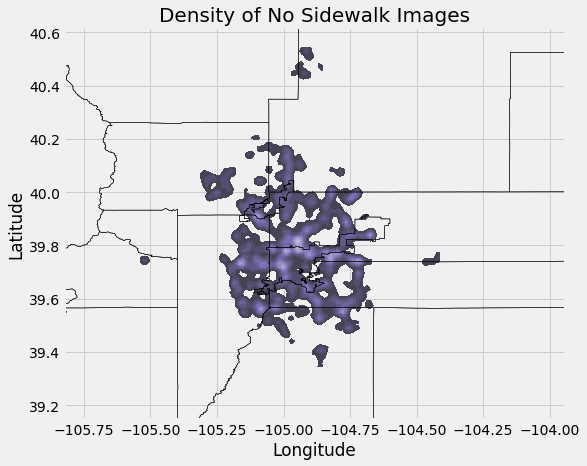

In [289]:
location_plotter(no_sidewalk_loc_xy, "No Sidewalk")

In [291]:
def polar_plotter(dataset, title_insert):   
    figp = plt.figure(figsize=(86,6))
    axp = figp.add_subplot(111, projection='polar')
    axp.set_theta_zero_location('N')
    axp.set_theta_direction(-1)
    axp.set_yticklabels("")
    sns.kdeplot(dataset*pi/180, #needs radian
                clip=(0,360),
                cut=0,
                ax=axp)
    axp.set_title(f'Camera Direction for {title_insert} Images', fontsize=20);

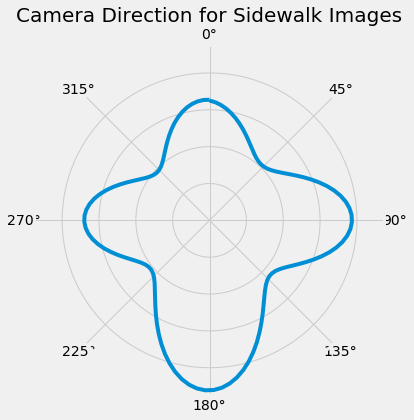

In [292]:
polar_plotter(sidewalk_loc_headings, "Sidewalk")

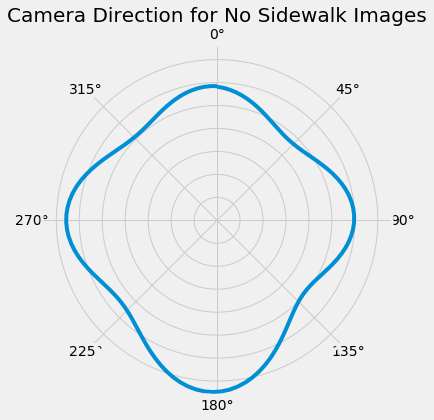

In [293]:
polar_plotter(no_sidewalk_loc_headings, "No Sidewalk")